# Train LDA and Word2Vec Models

This notebook includes code to train and evaluate both LDA and Word2Vec models. <br>

The 'compiled_recipes' dataframe was split into a training set and a test set. Each dataframe was pickled and can be found at https://tinyurl.com/yyanydd4.

In [1]:
import pickle
import matplotlib.pyplot as plt
from gensim import models, corpora
import pandas as pd
import numpy as np

import pyLDAvis
import pyLDAvis.gensim

import seaborn as sns

#### 10,000 recipes from 'compiled_recipes' dataframe were set aside for the test set 

In [2]:
with open('df_train.pickle', 'rb') as f:
    df_train = pickle.load(f)

with open('df_test.pickle', 'rb') as f:
    df_test = pickle.load(f)

### LDA with 4 topics

In [ ]:
num_topics = 4

dictionary = corpora.Dictionary(df_train['instructions'])
corpus = [dictionary.doc2bow(text) for text in df_train['instructions']]

lda_model = models.LdaModel(corpus=corpus, 
                            num_topics=num_topics, 
                            alpha = [.01]*num_topics,
                            iterations = 100,
                            passes = 10,
                            id2word=dictionary)

In [ ]:
'''
lda_model.save('lda_model_10p4t_full_training.gensim')
dictionary.save('lda_10p4t_full_training_dictionary')
'''

In [3]:
## load LDA model
lda_model = models.LdaModel.load('lda_model_10p4t_full_training.gensim')
dictionary = corpora.Dictionary.load('lda_10p4t_full_training_dictionary')

### Visualize topics using pyLDAvis

In [ ]:
pyLDAvis.enable_notebook()

#dictionary = corpora.Dictionary(df_train['instructions'])
corpus = [dictionary.doc2bow(text) for text in df_train['instructions']]
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics = False)
vis

In general, the topics correspond to: <br><br>
Topic 1: stovetop meals<br>
Topic 2: cold items and drinks<br>
Topic 3: oven and grill meals<br>
Topic 4: baked sweets<br>

### Plot max weight distribution

In [4]:
recipes_max_weight = []
for i in df_train['instructions']:
    bow = dictionary.doc2bow(i)
    weights = lda_model[bow]
    max_weight = sorted(weights, key=lambda x: x[1])[-1:][0][1]
    recipes_max_weight.append(max_weight)

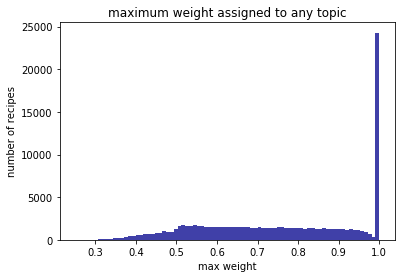

In [5]:
n, bins, patches = plt.hist(recipes_max_weight, 80, facecolor='darkblue', alpha=0.75)
plt.xlabel("max weight")
plt.ylabel("number of recipes")
plt.title("maximum weight assigned to any topic")
plt.show()

Parameters for LDA selected to maximize the number of recipes with a maximum assigned weight of ~1, and minimize the area under the curve of max weight distribution.

## Train word embeddings based on all data

In [6]:
full_model = models.Word2Vec(size=200, #number of features (dimensions)
                               window=20, #window size encompasses entire list of ingredients
                               min_count=20, #minimum instances of word in corpus to be included
                               workers=6,
                               sample = 5e-5, #randomly downsample common words
                               sg = 1) #skipgram method
full_model.build_vocab(df_train['ingredients'])
full_model.train(df_train['ingredients'],
            total_examples=full_model.corpus_count, 
            epochs=100)

(16114604, 99002100)

In [7]:
## load trained model
full_model = models.Word2Vec.load('full_model_0206.model')

### Evaluate model using the top suggestion for each staple

Staples are labelled as either a protein, vegetable, spice, grain, fruit, oil, or liquid. These primarily correspond to the Viome app food labels, with some groups being further subsetted. <br>

Accuracy is determined based on whether the most similar staple falls into the same group of food is the input staple. To obtain a more representative view of the actual dataset, results are aggregated for all staples in a set of 10,000 recipes rather than for each individual staple.

In [8]:
##list of staples
df_staples = pd.read_csv('staples_tagged_singular.csv')
all_staples = list(df_staples['AbbrvName'])

In [9]:
recipes = df_test['ingredients']

model = full_model
vocab = model.wv.vocab
staple_cats = list(df_staples['Group'])

saved_results = {}
val_list_full = []
for recipe in recipes:
    
    ## reduce ingredient lists to staples for comparison
    staples_in = [i for i in recipe if i in all_staples]
    for staple in staples_in:
        if staple not in vocab:
            continue
        else:
            
            ## output results for staple if previously assessed
            if staple in saved_results:
                val_list_full.append(saved_results[staple])
            else:
                
                ## get most similar foods to given staple (cosine similarity)
                similar_foods = model.wv.most_similar(staple, topn = 5)
                
                ## exclude non-staples suggestions
                similar_staples = [i[0] for i in similar_foods if i[0] in all_staples]
                if similar_staples:
                    
                    ## determine if staple and suggestion categories match
                    in_group = staple_cats[all_staples.index(staple)]
                    out_group = staple_cats[all_staples.index(similar_staples[0])]
                    output = (in_group == out_group, in_group)
                    
                    ## output results and save results for staple to dictionary
                    val_list_full.append(output)
                    saved_results[staple] = output
  

#### print accuracy for each category of food

In [10]:
for group in df_staples['Group'].unique():
    results = [x[0] for x in val_list_full if x[1] == group]
    print(group, np.mean(results))

p 0.7340388007054673
v 0.9078223810833104
s 0.4793075684380032
g 0.6532846715328468
f 0.6802753011105898
o 0.0
l 0.996958174904943


The model is unable to substitute oils with other oils. This may be driven by severe underrepresentation of alternative cooking oils in the dataset.

Liquids *appear* to perform well. However, this is driven almost entirely by vinegar (for which the suggested replacement is apple cider vinegar, and vice versa). 

In [23]:
## for visualizing (see end of notebook)
results = [[]]
for group in df_staples['Group'].unique()[:5]:
    acc = np.mean([x[0] for x in val_list_full if x[1] == group])
    results[0].append(acc)
    

In [24]:
results

[[0.7340388007054673,
  0.9078223810833104,
  0.4793075684380032,
  0.6532846715328468,
  0.6802753011105898]]

## Train word embeddings per topic


In [13]:
recipes_topics = []
recipes_max_weight = []
for i in df_train['instructions']:
    bow = dictionary.doc2bow(i)
    weights = lda_model[bow]
    t_w = sorted(weights, key=lambda x: x[1])[-1:][0]
    recipes_topics.append(t_w[0])
    recipes_max_weight.append(t_w[1])

df_train['topic'] = recipes_topics
df_train['weight'] = recipes_max_weight

In [14]:
## restrict to recipes with majority of weight assigned to 1 topic

df_train2 = df_train.loc[df_train['weight'] > .5]

In [15]:
##train word2vec with 1 topic per recipe
def model_n_save(df_topic):
    model = models.Word2Vec(
        size=200,
        window=20,
        min_count=20,
        workers=6,
        sample = 5e-5,
        sg = 1)
    model.build_vocab(df_topic['ingredients'])
    model.train(df_topic['ingredients'], 
                total_examples=model.corpus_count, 
                epochs=100)
    return model

by_topic = df_train2.groupby('topic')
w2v_models_single = by_topic.apply(model_n_save)


In [16]:
## load trained models

w2v_models_single = []
for i in range(4):
    file = 'w2v_topic'+ str(i)+ '_fulltrain.model'
    model = models.Word2Vec.load(file)
    w2v_models_single.append(model)

### Evaluate each model using the top suggestion for each staple

In [17]:
recipes = df_test['ingredients']

staple_cats = list(df_staples['Group'])

saved_results = [{}, {}, {}, {}]
val_list = []
for recipe in recipes:
    
    ## apply LDA for topic assignment
    bow = dictionary.doc2bow(recipe)
    topic = sorted(lda_model[bow], key=lambda x: x[1])[-1:][0][0]
    
    ## select word2vec model for designated topic
    model = w2v_models_single[topic]
    
    ## reduce ingredient lists to staples for comparison
    staples_in = [i for i in recipe if i in all_staples]
    
    for staple in staples_in:
        if staple not in model.wv.vocab:
            continue
        else:
            ## output results for staple if previously assessed
            if staple in saved_results[topic]:
                val_list.append(saved_results[topic][staple])
            else:
                ## get most similar foods to given staple (cosine similarity)
                similar_foods = model.wv.most_similar(staple, topn = 5)
                
                ## exclude non-staples suggestions
                similar_staples = [i[0] for i in similar_foods if i[0] in all_staples]
                if similar_staples:
                    
                    ## determine if staple and suggestion categories match
                    in_group = staple_cats[all_staples.index(staple)]
                    out_group = staple_cats[all_staples.index(similar_staples[0])]
                    output = (in_group == out_group, in_group, topic)
                    
                    ## output results and save results for staple to dictionary
                    val_list.append(output)
                    saved_results[topic][staple] = output

In [18]:
for group in df_staples['Group'].unique():
    results = [x[0] for x in val_list if x[1] == group]
    print(group, np.mean(results))

p 0.7614746420446943
v 0.5025324359952821
s 0.43382846906023736
g 0.6267605633802817
f 0.6387351778656126
o 0.0
l 0.8389897395422258


In [19]:
## print accuracy by topic
for topic in range(4):
    subset = [x for x in val_list if x[2] == topic]
    print('topic', topic+1)
    for group in df_staples['Group'].unique():
        results = [x[0] for x in subset if x[1] == group]
        print(group, np.mean(results))
        if group == 'l':
            print('\n')

topic 1
p 0.9035985956699825
v 0.3329446682213271
s 0.4336329984135378
g 0.9113475177304965
f 0.5271816881258942
o 0.0
l 0.8527724665391969


topic 2
p 0.4772727272727273
v 0.2631578947368421
s 0.2231404958677686
g 0.0
f 0.7649363369245837
o 0.0
l 0.0


topic 3
p 0.884504834073687
v 0.8624945864010394
s 0.3736867239732569
g 0.0
f 0.3726641751201281
o 0.0
l 0.9195230998509687


topic 4
p 0.42124906693207265
v 0.33746130030959753
s 0.5376615190671289
g 0.09049773755656108
f 0.897196261682243
o 0.0
l 0.0




### Visualize performance

In [25]:
for topic in range(4):
    subset = [x for x in val_list if x[2] == topic]
    result = []
    for group in df_staples['Group'].unique()[:5]:
        acc = np.mean([x[0] for x in subset if x[1] == group])
        result.append(acc)
    results.append(result)

In [27]:
df_acc = pd.DataFrame({'full_model':results[0],
                      'savory - stove':results[1],
                      'cold/drinks':results[2],
                      'savory - oven':results[3],
                      'baked desserts':results[4]})

df_acc['Category'] = ['protein', 'vegetable', 'spice', 'grain', 'fruit']
df_acc.set_index('Category', inplace = True)

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text xticklabel objects>)

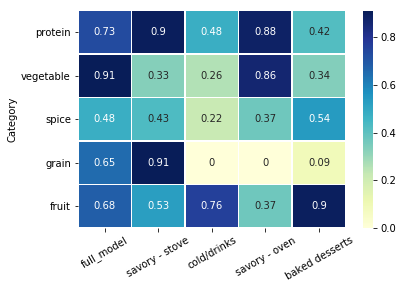

In [28]:
heater = sns.heatmap(df_acc, 
            annot = True, 
            cmap="YlGnBu", 
            linewidth=0.5
           )
plt.xticks(rotation=30)

### Conclusion

Compared to the model trained on the entire corpus, the topic-based word2vec models each perform better or worse for different subsets of food. This is likely due to the contents of the recipes assigned to each topic, which provide less context for certain types of food (such as a shortage of fruits among savory entrees).